### Gloden cross strategy

In [2]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

### import csv

In [23]:
data = pd.read_csv('ETHUSDT_4h.csv')
data.tail()

timestamp     open     high      low    close      volume  \
9232  1647936000000  2993.00  3027.27  2985.00  3020.74  78938.6739   
9233  1647950400000  3020.74  3030.15  2988.28  3002.76  83678.3436   
9234  1647964800000  3002.75  3013.87  2981.00  2984.52  65150.3774   
9235  1647979200000  2984.52  3016.39  2960.00  2969.64  53494.8922   
9236  1647993600000  2969.64  2992.66  2925.30  2947.00  81312.7604   

         close_time           qav  num_trades  taker_base_vol  \
9232  1647950399999  2.377243e+08      112140      40768.5968   
9233  1647964799999  2.518801e+08      120628      40285.5078   
9234  1647979199999  1.956302e+08       89833      32013.6126   
9235  1647993599999  1.601021e+08       86238      26883.9292   
9236  1648007999999  2.407763e+08      144381      38893.9704   

      taker_quote_vol  ignore  
9232     1.227845e+08       0  
9233     1.212862e+08       0  
9234     9.613750e+07       0  
9235     8.048253e+07       0  
9236     1.151871e+08       0

In [24]:
df = data.copy()

### Create strategy

In [22]:
gloden_cross = ta.Strategy(
    name = 'Gloden cross',
    description = 'Gloden cross by EMA 2 Line',
    ta = [
        {'kind': 'ema', 'length': 200},
        {'kind': 'ema', 'length': 10},
        {'kind': 'ema', 'length': 50}
    ]
)
df.ta.strategy(gloden_cross)

### Create signal

In [19]:
class BacktestGlodenCross:
    def __init__(self, params):
        self.orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L', 'result'])
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        self.unknow_result = []
        
        self.current_action = 'close'
        self.atr_len = params['atr_len']
        self.ema_1 = params['ema_1']
        self.ema_2 = params['ema_2']
        
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        self.df = params['df']
        self.plot = params['plot']
        
    def reset_order(self):
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
    def get_df(self):
        return self.df
        
    def plot_order(self, order):
        df = self.df.copy()
        df.set_index('timestamp', inplace = True)
        data_plot = df.loc[order['open time']:order['close time']]
        
        entry_line = np.empty(data_plot.shape[0])
        entry_line.fill(order['open'])

        tp_line = np.empty(data_plot.shape[0])
        tp_line.fill(order['T/P'])

        sl_line = np.empty(data_plot.shape[0])
        sl_line.fill(order['S/L'])

        ema_line1 = data_plot['EMA_'+str(self.ema_1)]
        ema_line2 = data_plot['EMA_'+str(self.ema_2)]
        ema_len_line = data_plot['EMA_200']
        
        ema1_plot = mpf.make_addplot(ema_line1, panel=0, color='blue', width=1.5)
        ema2_plot = mpf.make_addplot(ema_line2, panel=0, color='hotpink', width=1.5)
        ema_len_plot = mpf.make_addplot(ema_len_line, panel=0, color='gray', width=1.5)

        entry_plot = mpf.make_addplot(entry_line, panel=0, color='blue', width=1.5)
        tp_plot = mpf.make_addplot(tp_line, panel=0, color='green', linestyle = 'dashed', width=1)
        sl_plot = mpf.make_addplot(sl_line, panel=0, color='red', linestyle = 'dotted', width=2)
        
        mpf.plot(data_plot, 
                 type='candle', 
                 style='charles', 
                 addplot=[ema1_plot, ema2_plot, ema_len_plot, entry_plot, tp_plot, sl_plot], 
                 figsize=(8, 4))
        
    def backtest(self):
        n_bars = 3
        gloden_cross = ta.Strategy(
            name = 'Gloden cross',
            description = 'Gloden cross by EMA 2 Line',
            ta = [
                {'kind': 'ema', 'length': 200},
                {'kind': 'ema', 'length': self.ema_1},
                {'kind': 'ema', 'length': self.ema_2},
                {'kind': 'atr', 'length': self.atr_len}
            ]
        )
        self.df.ta.strategy(gloden_cross)
        self.df = self.df.copy().dropna()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['action'] = None
        
        self.df['entries'] = False
        self.df['exits'] = False
        self.df['short_entries'] = False
        self.df['short_exits'] = False
        self.df['price_action'] = self.df['close']
        
        for index, row in self.df.iterrows():
            entry = 0
            
            if self.current_action == 'close':
            
                if (row['EMA_'+str(self.ema_1)] > row['EMA_'+str(self.ema_2)]) and (row['low'] > row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 < ema_2 then buy.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] < pre_row['EMA_'+str(self.ema_2)]):
                                self.df.at[index, 'action'] = 'buy'
                                self.df.at[index, 'entries'] = True
                                self.df.at[index, 'price_action'] = row['open']
                                self.order['action'] = 'buy'
                                
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] - row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] + (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'buy'
                        
                elif (row['EMA_'+str(self.ema_1)] < row['EMA_'+str(self.ema_2)]) and (row['high'] < row['EMA_'+str(200)]):
                    # check if previous n bars ema_1 > ema_2 then sell.
                    if index > n_bars:
                        for pre_index, pre_row in self.df.iloc[index-n_bars:index].iterrows():
                            if (pre_row['EMA_'+str(self.ema_1)] > pre_row['EMA_'+str(self.ema_2)]):
                                self.df.at[index, 'action'] = 'sell'
                                self.df.at[index, 'short_entries'] = True
                                self.df.at[index, 'price_action'] = row['open']
                                self.order['action'] = 'sell'
                                
                                self.order['open time'] = row['timestamp']
                                self.order['open'] = row['open']
                                self.order['S/L'] = row['open'] + row['ATRr_'+str(self.atr_len)]
                                self.order['T/P'] = row['open'] - (self.rr * abs(row['open'] - self.order['S/L']))
                                self.current_action = 'sell'
        
            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['high'] >= self.order['T/P']:
                    self.df.at[index, 'exits'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['high'] >= self.order['S/L']:
                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'price_action'] = row['high']
                    
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['low'] <= self.order['T/P']:
                    self.df.at[index, 'short_exits'] = True
                    self.df.at[index, 'price_action'] = row['low']
                    
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

        try:
            win_rate = round(len(self.orders[self.orders['result'] == 'T/P']) * 100 / len(self.orders), 2)
            loss_rate = round(len(self.orders[self.orders['result'] == 'S/L']) * 100 / len(self.orders), 2)

            win_orders = int((win_rate * len(self.orders)) / 100 )
            loss_orders = len(self.orders) - win_orders
            gain = (win_orders * self.rr) - loss_orders

            result_info = f"total orders: {len(self.orders)}\nema_1: {self.ema_1}, ema_2: {self.ema_2}, atr: {self.atr_len}, gain: {gain}\n"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': len(self.orders), 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
    #         print("No orders to action")
            return {'win_rate': 0, 'info': 'No orders to action'}

In [25]:
pair_test = BacktestGlodenCross({
    'atr_len': 14,
    'ema_1': 10,
    'ema_2': 20,
    'pip_value': 0.001,
    'rr': 1.5,
    'plot': False,
    'df': df.copy()
})
pair_test.backtest()

{'win_rate': 48.38,
 'info': 'total orders: 802\nema_1: 10, ema_2: 20, atr: 14, gain: 168.0\n',
 'total_order': 802,
 'rr': 1.5,
 'gain': 168.0,
 'unknow': [timestamp          1970-01-01 00:25:40.987200
  open                                   196.91
  high                                   201.45
  low                                    193.01
  close                                  199.36
  volume                            45968.87482
  close_time                      1541001599999
  qav                            9037775.490148
  num_trades                              21311
  taker_base_vol                    23216.55836
  taker_quote_vol                4564399.605324
  ignore                                      0
  EMA_200                            213.134289
  EMA_10                             198.030959
  EMA_20                             199.388361
  ATRr_14                              2.258904
  action                                   None
  entries                    

In [7]:
pair_df = pair_test.get_df().copy()
pair_df

timestamp      open      high       low     close  \
199  2021-11-08 21:15:00+00:00  0.742661  0.742832  0.742589  0.742694   
200  2021-11-08 21:30:00+00:00  0.742699  0.743052  0.742583  0.742721   
201  2021-11-08 21:45:00+00:00  0.742561  0.742887  0.742517  0.742639   
202  2021-11-08 22:00:00+00:00  0.742721  0.742887  0.742583  0.742721   
203  2021-11-08 22:15:00+00:00  0.742672  0.742887  0.742341  0.742462   
...                        ...       ...       ...       ...       ...   
7846 2022-03-01 15:45:00+00:00  0.726860  0.726860  0.725768  0.726201   
7847 2022-03-01 16:00:00+00:00  0.726058  0.726375  0.725663  0.725779   
7848 2022-03-01 16:15:00+00:00  0.725768  0.726216  0.725595  0.725811   
7849 2022-03-01 16:30:00+00:00  0.725679  0.725953  0.725431  0.725442   
7850 2022-03-01 16:45:00+00:00  0.725395  0.725637  0.724627  0.724785   

      adj close  volumn   EMA_200    EMA_10    EMA_36   ATRr_14 action  \
199    0.742694       0  0.740150  0.742592  0.742165  0.000545    buy   
200    0.742721       0  0.740176  0.742616  0.742195  0.000539   None   
201    0.742639       0  0.740200  0.742620  0.742219  0.000527   None   
202    0.742721       0  0.740226  0.742638  0.742246  0.000511   None   
203    0.742462       0  0.740248  0.742606  0.742258  0.000514   None   
...         ...     ...       ...       ...       ...       ...    ...   
7846   0.726201       0  0.724297  0.726824  0.727007  0.000811   None   
7847   0.725779       0  0.724312  0.726634  0.726941  0.000804   None   
7848   0.725811       0  0.724327  0.726485  0.726880  0.000791   None   
7849   0.725442       0  0.724338  0.726295  0.726802  0.000772   None   
7850   0.724785       0  0.724342  0.726020  0.726693  0.000789   None   

      entries  exits  short_entries  short_exits  price_action  
199      True  False          False        False      0.742661  
200     False  False          False        False      0.742721  
201     False  False          False        False      0.742639  
202     False  False          False        False      0.742721  
203     False  False          False        False      0.742462  
...       ...    ...            ...          ...           ...  
7846    False  False          False        False      0.726201  
7847    False  False          False        False      0.725779  
7848    False  False          False        False      0.725811  
7849    False  False          False        False      0.725442  
7850    False  False          False        False      0.724785  

[7652 rows x 17 columns]

In [8]:
pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'], unit='ms')
pair_df = pair_df.set_index('timestamp')
pair_df

open      high       low     close  adj close  \
timestamp                                                                      
2021-11-08 21:15:00+00:00  0.742661  0.742832  0.742589  0.742694   0.742694   
2021-11-08 21:30:00+00:00  0.742699  0.743052  0.742583  0.742721   0.742721   
2021-11-08 21:45:00+00:00  0.742561  0.742887  0.742517  0.742639   0.742639   
2021-11-08 22:00:00+00:00  0.742721  0.742887  0.742583  0.742721   0.742721   
2021-11-08 22:15:00+00:00  0.742672  0.742887  0.742341  0.742462   0.742462   
...                             ...       ...       ...       ...        ...   
2022-03-01 15:45:00+00:00  0.726860  0.726860  0.725768  0.726201   0.726201   
2022-03-01 16:00:00+00:00  0.726058  0.726375  0.725663  0.725779   0.725779   
2022-03-01 16:15:00+00:00  0.725768  0.726216  0.725595  0.725811   0.725811   
2022-03-01 16:30:00+00:00  0.725679  0.725953  0.725431  0.725442   0.725442   
2022-03-01 16:45:00+00:00  0.725395  0.725637  0.724627  0.724785   0.724785   

                           volumn   EMA_200    EMA_10    EMA_36   ATRr_14  \
timestamp                                                                   
2021-11-08 21:15:00+00:00       0  0.740150  0.742592  0.742165  0.000545   
2021-11-08 21:30:00+00:00       0  0.740176  0.742616  0.742195  0.000539   
2021-11-08 21:45:00+00:00       0  0.740200  0.742620  0.742219  0.000527   
2021-11-08 22:00:00+00:00       0  0.740226  0.742638  0.742246  0.000511   
2021-11-08 22:15:00+00:00       0  0.740248  0.742606  0.742258  0.000514   
...                           ...       ...       ...       ...       ...   
2022-03-01 15:45:00+00:00       0  0.724297  0.726824  0.727007  0.000811   
2022-03-01 16:00:00+00:00       0  0.724312  0.726634  0.726941  0.000804   
2022-03-01 16:15:00+00:00       0  0.724327  0.726485  0.726880  0.000791   
2022-03-01 16:30:00+00:00       0  0.724338  0.726295  0.726802  0.000772   
2022-03-01 16:45:00+00:00       0  0.724342  0.726020  0.726693  0.000789   

                          action  entries  exits  short_entries  short_exits  \
timestamp                                                                      
2021-11-08 21:15:00+00:00    buy     True  False          False        False   
2021-11-08 21:30:00+00:00   None    False  False          False        False   
2021-11-08 21:45:00+00:00   None    False  False          False        False   
2021-11-08 22:00:00+00:00   None    False  False          False        False   
2021-11-08 22:15:00+00:00   None    False  False          False        False   
...                          ...      ...    ...            ...          ...   
2022-03-01 15:45:00+00:00   None    False  False          False        False   
2022-03-01 16:00:00+00:00   None    False  False          False        False   
2022-03-01 16:15:00+00:00   None    False  False          False        False   
2022-03-01 16:30:00+00:00   None    False  False          False        False   
2022-03-01 16:45:00+00:00   None    False  False          False        False   

                           price_action  
timestamp                                
2021-11-08 21:15:00+00:00      0.742661  
2021-11-08 21:30:00+00:00      0.742721  
2021-11-08 21:45:00+00:00      0.742639  
2021-11-08 22:00:00+00:00      0.742721  
2021-11-08 22:15:00+00:00      0.742462  
...                                 ...  
2022-03-01 15:45:00+00:00      0.726201  
2022-03-01 16:00:00+00:00      0.725779  
2022-03-01 16:15:00+00:00      0.725811  
2022-03-01 16:30:00+00:00      0.725442  
2022-03-01 16:45:00+00:00      0.724785  

[7652 rows x 16 columns]

In [9]:
pair_df[pair_df['exits'] == True]

open      high       low     close  adj close  \
timestamp                                                                      
2021-11-08 23:00:00+00:00  0.742319  0.742446  0.741977  0.742115   0.742115   
2021-11-09 00:00:00+00:00  0.741559  0.741950  0.741361  0.741620   0.741620   
2021-11-09 05:45:00+00:00  0.742143  0.742666  0.741944  0.742027   0.742027   
2021-11-09 07:00:00+00:00  0.742391  0.743163  0.742220  0.743163   0.743163   
2021-11-09 07:30:00+00:00  0.742335  0.742446  0.741724  0.742335   0.742335   
...                             ...       ...       ...       ...        ...   
2022-02-22 18:45:00+00:00  0.721007  0.721241  0.720497  0.720882   0.720882   
2022-02-25 11:00:00+00:00  0.720196  0.720409  0.719042  0.719155   0.719155   
2022-02-25 12:45:00+00:00  0.720191  0.722089  0.719937  0.721631   0.721631   
2022-02-25 13:45:00+00:00  0.722575  0.723327  0.722100  0.723113   0.723113   
2022-02-25 14:15:00+00:00  0.722538  0.723380  0.722293  0.722752   0.722752   

                           volumn   EMA_200    EMA_10    EMA_36   ATRr_14  \
timestamp                                                                   
2021-11-08 23:00:00+00:00       0  0.740310  0.742479  0.742272  0.000520   
2021-11-09 00:00:00+00:00       0  0.740366  0.742060  0.742164  0.000507   
2021-11-09 05:45:00+00:00       0  0.740454  0.741384  0.741270  0.000660   
2021-11-09 07:00:00+00:00       0  0.740554  0.742132  0.741572  0.000664   
2021-11-09 07:30:00+00:00       0  0.740591  0.742226  0.741662  0.000675   
...                           ...       ...       ...       ...       ...   
2022-02-22 18:45:00+00:00       0  0.720503  0.721627  0.721657  0.000745   
2022-02-25 11:00:00+00:00       0  0.719098  0.719740  0.719177  0.000835   
2022-02-25 12:45:00+00:00       0  0.719184  0.720358  0.719575  0.000892   
2022-02-25 13:45:00+00:00       0  0.719313  0.721580  0.720158  0.000895   
2022-02-25 14:15:00+00:00       0  0.719379  0.721943  0.720423  0.000949   

                          action  entries  exits  short_entries  short_exits  \
timestamp                                                                      
2021-11-08 23:00:00+00:00   None    False   True          False        False   
2021-11-09 00:00:00+00:00   None    False   True          False        False   
2021-11-09 05:45:00+00:00   None    False   True          False        False   
2021-11-09 07:00:00+00:00   None    False   True          False        False   
2021-11-09 07:30:00+00:00   None    False   True          False        False   
...                          ...      ...    ...            ...          ...   
2022-02-22 18:45:00+00:00   None    False   True          False        False   
2022-02-25 11:00:00+00:00   None    False   True          False        False   
2022-02-25 12:45:00+00:00   None    False   True          False        False   
2022-02-25 13:45:00+00:00   None    False   True          False        False   
2022-02-25 14:15:00+00:00   None    False   True          False        False   

                           price_action  
timestamp                                
2021-11-08 23:00:00+00:00      0.741977  
2021-11-09 00:00:00+00:00      0.741361  
2021-11-09 05:45:00+00:00      0.742666  
2021-11-09 07:00:00+00:00      0.743163  
2021-11-09 07:30:00+00:00      0.741724  
...                                 ...  
2022-02-22 18:45:00+00:00      0.720497  
2022-02-25 11:00:00+00:00      0.719042  
2022-02-25 12:45:00+00:00      0.722089  
2022-02-25 13:45:00+00:00      0.723327  
2022-02-25 14:15:00+00:00      0.722293  

[293 rows x 16 columns]

In [42]:
port = vbt.Portfolio.from_signals(pair_df.price_action,
                                  entries=pair_df.entries.astype('bool'),
                                  exits=pair_df.exits.astype('bool'),
                                  short_entries=pair_df.short_entries.astype('bool'),
                                  short_exits=pair_df.short_exits.astype('bool'),
                                  freq="15m",
                                  size=5,
#                                   size_type='value',
                                  init_cash=100,
                                  fees=0, # 0.0025,
                                  slippage=0 # 0.0025
                                 )

In [43]:
port.plot().show()

<AxesSubplot:xlabel='timestamp'>

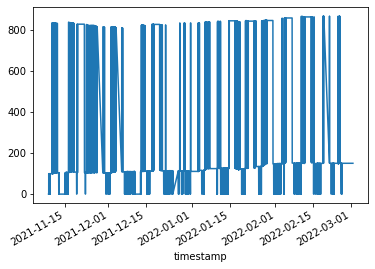

In [26]:
port.cash().plot()

In [27]:
port.stats()

Start                         2021-11-08 21:15:00+00:00
End                           2022-03-01 16:45:00+00:00
Period                                 79 days 17:00:00
Start Value                                       100.0
End Value                                     150.65705
Total Return [%]                               50.65705
Benchmark Return [%]                          -2.407009
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               8.134843
Max Drawdown Duration                  12 days 11:45:00
Total Trades                                        586
Total Closed Trades                                 586
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  49.829352
Best Trade [%]                                 0.549107
Worst Trade [%]                               -0

In [26]:
"""
Grid parameter example
line 1: 10 -> 40
line 2: 20 -> 80
condition line 1 < line 2 < line 3
"""
def create_grid_params(line1_start, line1_end, line2_start, line2_end):
    params = []
    for i in range(line1_start, line1_end+1):
        for j in range(line2_start, line2_end+1):
            if( i < j ):
                params.append([i, j])
    return params
params_list = create_grid_params(10, 40, 20, 50)
len(params_list)

730

In [27]:
good_params = {'win': 0, 'info': ''}
start = 0
end = 730
win_start = 0

loop_num = start
for param in params_list[start:end]:
    obj = BacktestGlodenCross({'atr_len': 14, 'ema_1': param[0], 'ema_2': param[1], 'pip_value': 0.001, 'rr': 1.5, 'df': df.copy(), 'plot': False})
    result = obj.backtest()
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

run: 730 to 730
win rate: 48.38 %
total orders: 802
ema_1: 10, ema_2: 20, atr: 14, gain: 168.0



#### AUDUSD 15m
* win rate: 46.86 %
* total orders: 668
* ema_1: 10, ema_2: 36, atr: 14, gain: 114.5

#### EURUSD 15m
* win rate: 45.36 %
* total orders: 560
* ema_1: 10, ema_2: 26, atr: 14, gain: 75.0

#### GBPUSD 15m
* win rate: 43.56 %
* total orders: 675
* ema_1: 10, ema_2: 32, atr: 14, gain: 60.0

#### USDJPY 15m
* win rate: 42.21 %
* total orders: 488
* ema_1: 30, ema_2: 47, atr: 14, gain: 24.5

#### BTCUSDT 1d
* win rate: 59.05 %
* total orders: 105
* ema_1: 11, ema_2: 47, atr: 14, gain: 50.0

#### BTCUSDT 4h
* win rate: 45.48 %
* total orders: 730
* ema_1: 10, ema_2: 20, atr: 14, gain: 100.0

#### ETHUSDT 1d
* win rate: 52.83 %
* total orders: 106
* ema_1: 10, ema_2: 38, atr: 14, gain: 31.5

#### ETHUSDT 4h
* win rate: 48.38 %
* total orders: 802
* ema_1: 10, ema_2: 20, atr: 14, gain: 168.0

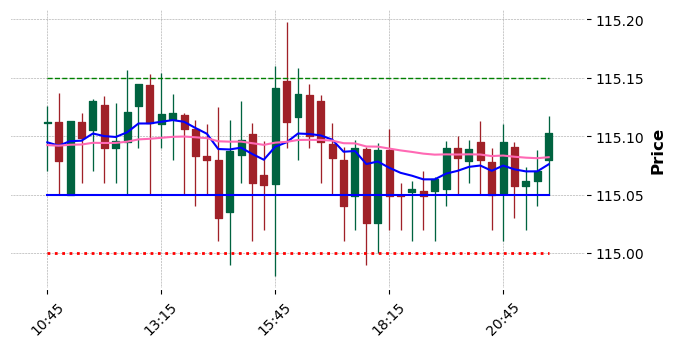

In [78]:
data_test = df.copy()
new_timestamp = data_test['timestamp'].str.split('+', n = 1, expand = True)
data_test['timestamp'] = new_timestamp[0]
data_test['timestamp'] = pd.to_datetime(data_test['timestamp'])
data_test.set_index('timestamp', inplace = True)

ema_line = data_test['EMA_10'].loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']
ema_line2 = data_test['EMA_50'].loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']

data_test_plot = data_test.loc['2021-12-31 10:45:00': '2021-12-31 21:45:00']
entry_line = np.empty(data_test_plot.shape[0])
entry_line.fill(115.05)

tp_line = np.empty(data_test_plot.shape[0])
tp_line.fill(115.15)

sl_line = np.empty(data_test_plot.shape[0])
sl_line.fill(115.00)

ema1_plot = mpf.make_addplot(ema_line, panel=0, color='blue', width=1.5)
ema2_plot = mpf.make_addplot(ema_line2, panel=0, color='hotpink', width=1.5)

entry_plot = mpf.make_addplot(entry_line, panel=0, color='blue', width=1.5)
tp_plot = mpf.make_addplot(tp_line, panel=0, color='green', linestyle = 'dashed', width=1)
sl_plot = mpf.make_addplot(sl_line, panel=0, color='red', linestyle = 'dotted', width=2)

# two_lines = { 'alines': [ema_line, ema_line2], 'colors': ['b', 'g'] }
mpf.plot(data_test_plot, 
         type='candle', style='charles',
         addplot=[ema1_plot, ema2_plot, entry_plot, tp_plot, sl_plot],
         figsize=(8, 4))